<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day 20: Interpolation and Resampling"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 20, March 19, 2019</h4>

### Introduction

Suppose we want to compute a similarity metric using say, MSE, between the moving imaging and the fixed image under a rigid body transformation. If there is a rotation involved, then in general these two images are not grid-aligned. Similarily, if the two images/volume have different pixel/voxel sizes, we won't be able to find 1-to-1 mapping between pixel/voxels to perform the said computation.

The solution is to **resample** one of the image (typically the moving image) such that, after resampling, the resampled image has the same pixel size and same (conceptually) orientation as the other image.

The resampling is best conceptualized as applying a *resampling grid* to the image. If one is to conceptualize the resampling grid as an empty array, then the tasking as resampling is to fill in the value of the array based on the image of which grid is being placed upon.

<img src="resampling.svg"/><br><br>

Resampling as the verb is the action of sampling an image, which itself is a sampling of an original continuous signal.

Generally speaking, resampling in SimpleITK involves four components:
1. Image - the image we resample, given in coordinate system $m$,
2. Resampling grid - a regular grid of points given in the coordinate system $f$ which will be mapped to coordinate system $m$,
3. Transformation $^{m}T_{f}$ - maps points from coordinate system $f$ to coordinate system $m$, $^{m}p = ^{m}T_{f} (^{f}p)$,
4. Interpolator - method for obtaining the intensity values at arbitrary points in coordinate system $m$ from the values of the points defined by the image.

While SimpleITK provides a large number of interpolation methods, the two most commonly used are ```sitkLinear``` and ```sitkNearestNeighbor```. The former is used for most interpolation tasks, a compromise between accuracy and computational efficiency. The later is used to interpolate labeled image representing a segmentation, it is the only interpolation approach which will **not** introduce new labels into the results.

SimpleITK's procedureal API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:

1. ```Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
2. ```Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
3. ```Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

In [1]:
import SimpleITK as sitk

import numpy as np
import os

import math
from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
%matplotlib inline

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

OUTPUT_DIR = 'output'

Fetching SimpleITK.jpg


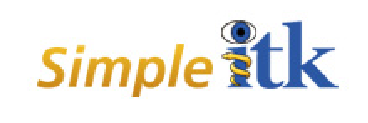

In [2]:
logo = sitk.ReadImage(fdata('SimpleITK.jpg'))

# GetArrayViewFromImage returns an immutable numpy array view to the data.
plt.imshow(sitk.GetArrayViewFromImage(logo))
plt.axis('off');

In [3]:
def resample_display(image, euler2d_transform, tx, ty, theta):
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)
    
    resampled_image = sitk.Resample(image, euler2d_transform)
    plt.imshow(sitk.GetArrayFromImage(resampled_image))
    plt.axis('off')    
    plt.show()

euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))
interact(resample_display, image=fixed(logo), euler2d_transform=fixed(euler2d), tx=(-128.0, 128.0,2.5), ty=(-64.0, 64.0), theta=(-np.pi/4.0,np.pi/4.0));

interactive(children=(FloatSlider(value=-0.5, description='tx', max=128.0, min=-128.0, step=2.5), FloatSlider(…

### Common Errors

It is not uncommon to end up with an empty (all black) image after resampling. This is due to:
1. Using wrong settings for the resampling grid, not too common, but does happen.
2. Using the inverse of the transformation $T_f^m$. This is a relatively common error, which is readily addressed by invoking the transformations ```GetInverse``` method.

### Defining the Resampling Grid

In the example above we arbitrarily used the original image grid as the resampling grid. As a result, for many of the transformations the resulting image contained black pixels, pixels which were mapped outside the spatial domain of the original image and a partial view of the original image.

If we want the resulting image to contain all of the original image no matter the transformation, we will need to define the resampling grid using our knowledge of the original image's spatial domain and the **inverse** of the given transformation. 

Computing the bounds of the resampling grid when dealing with an affine transformation is straightforward. An affine transformation preserves convexity with extreme points mapped to extreme points. Thus we only need to apply the **inverse** transformation to the corners of the original image to obtain the bounds of the resampling grid.

Computing the bounds of the resampling grid when dealing with a BSplineTransform or DisplacementFieldTransform is more involved as we are not guaranteed that extreme points are mapped to extreme points. This requires that we apply the **inverse** transformation to all points in the original image to obtain the bounds of the resampling grid.  

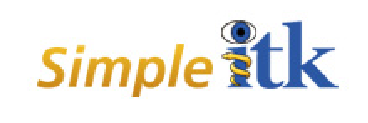

In [4]:
euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))

tx = 64
ty = 32
euler2d.SetTranslation((tx, ty))

extreme_points = [logo.TransformIndexToPhysicalPoint((0,0)), 
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),0)),
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),logo.GetHeight())),
                  logo.TransformIndexToPhysicalPoint((0,logo.GetHeight()))]
inv_euler2d = euler2d.GetInverse()

extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
min_x = min(extreme_points_transformed)[0]
min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
max_x = max(extreme_points_transformed)[0]
max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()
# Identity cosine matrix (arbitrary decision).   
output_direction = [1.0, 0.0, 0.0, 1.0]
# Minimal x,y coordinates are the new origin.
output_origin = [min_x, min_y]
# Compute grid size based on the physical size and spacing.
output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

resampled_image = sitk.Resample(logo, output_size, euler2d, sitk.sitkLinear, output_origin, output_spacing, output_direction)
plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis('off')    
plt.show()

Are you puzzled by the result? Is the output just a copy of the input? Add a rotation to the code above and see what happens (```euler2d.SetAngle(0.79)```).

### Expand With Interpolators

To understand this a bit more, let us look into the Interpolators in detail.

There are many different interpolators available in SimpleITK for image resampling.  Their effect is demonstrated on the <a href="http://www.cs.cornell.edu/~srm/publications/Vis94-filters-abstract.html">Marschner-Lobb</a> image.

In [5]:
def marschner_lobb(size=40, alpha=0.25, f_M=6.0):
    img = sitk.PhysicalPointSource(sitk.sitkVectorFloat32, [size]*3, [-1]*3, [2.0/size]*3)
    imgx = sitk.VectorIndexSelectionCast(img, 0)
    imgy = sitk.VectorIndexSelectionCast(img, 1)
    imgz = sitk.VectorIndexSelectionCast(img, 2)
    del img
    r = sitk.Sqrt(imgx**2 + imgy**2)
    del imgx, imgy
    pr = sitk.Cos((2.0*math.pi*f_M)*sitk.Cos((math.pi/2.0)*r))
    return (1.0 - sitk.Sin((math.pi/2.0)*imgz) + alpha*(1.0+pr))/(2.0*(1.0+alpha))

In [6]:
def myshow(img, title=None, margin=0.05):
    
    if (img.GetDimension() == 3):
        img = sitk.Tile( (img[img.GetSize()[0]//2,:,:],
                          img[:,img.GetSize()[1]//2,:],
                          img[:,:,img.GetSize()[2]//2]), [2,2])
            
    
    aimg = sitk.GetArrayViewFromImage(img)
    
    xsize,ysize = aimg.shape

    dpi=80
    
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1+margin)*ysize / dpi, (1+margin)*xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    t = ax.imshow(aimg)
    if len(aimg.shape) == 2:
        t.set_cmap("gray")
    if(title):
        plt.title(title)
    plt.show()

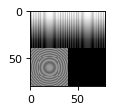

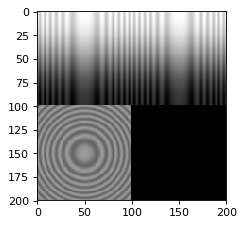

In [7]:
myshow(marschner_lobb())
myshow(marschner_lobb(100))

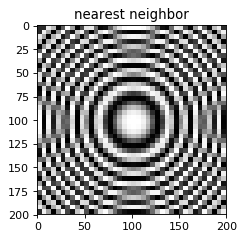

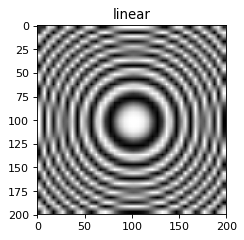

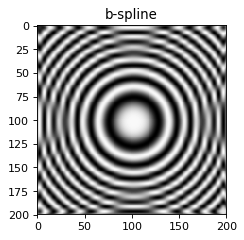

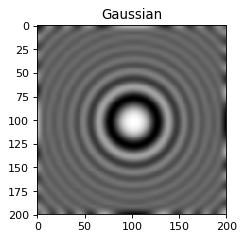

In [8]:
ml = marschner_lobb()
ml = ml[:,:,ml.GetSize()[-1]//2]
myshow(sitk.Expand(ml, [5]*3, sitk.sitkNearestNeighbor), title="nearest neighbor")
myshow(sitk.Expand(ml, [5]*3, sitk.sitkLinear), title="linear")
myshow(sitk.Expand(ml, [5]*3, sitk.sitkBSpline), title="b-spline")
myshow(sitk.Expand(ml, [5]*3, sitk.sitkGaussian), title="Gaussian")
#myshow(sitk.Expand(ml, [5]*3, sitk.sitkHammingWindowedSinc), title="Hamming windowed sinc")
#myshow(sitk.Expand(ml, [5]*3, sitk.sitkBlackmanWindowedSinc), title="Blackman windowed sinc")
#myshow(sitk.Expand(ml, [5]*3, sitk.sitkCosineWindowedSinc), title="Cosine windowed sinc")
#myshow(sitk.Expand(ml, [5]*3, sitk.sitkWelchWindowedSinc), title="Welch windowed sinc")
#myshow(sitk.Expand(ml, [5]*3, sitk.sitkLanczosWindowedSinc), title="Lanczos windowed sinc")